In [74]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("meteostat_kn.csv")
df.columns = ['date', 'hour', 'temp', 'dew_point', 'humidity', 'precipitation', 'snow', 'wind_direction', 'wind_speed', 'wind_gust', 'pressure', 'sunshine_minutes', 'code']

# Remove rows where the date is newer than the current date
current_date = datetime.now().date()
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' column is in datetime format
df = df[df['date'] < datetime(current_date.year, current_date.month, current_date.day)]
df.tail()

,date,hour,temp,dew_point,humidity,precipitation,snow,wind_direction,wind_speed,wind_gust,pressure,sunshine_minutes,code
591629,2025-05-05,19,6.7,6.1,96.0,0.0,NaN,36.0,14.8,29.6,1013.6,NaN,7.0
591630,2025-05-05,20,6.9,5.8,93.0,0.0,NaN,33.0,14.8,29.6,1013.7,NaN,7.0
591631,2025-05-05,21,6.7,6.0,95.0,0.0,NaN,33.0,14.8,29.6,1013.9,NaN,7.0
591632,2025-05-05,22,7.0,5.8,92.0,0.0,NaN,34.0,14.8,29.6,1013.9,NaN,7.0
591633,2025-05-05,23,7.2,5.8,91.0,0.0,NaN,36.0,14.8,29.6,1013.9,NaN,7.0


In [94]:
df["temp_dew_point_diff"] = df["temp"] - df["dew_point"]

In [95]:
features = ['hour', 'temp', 'dew_point', 'temp_dew_point_diff', 'humidity', 'pressure', 'wind_speed', 'wind_gust']
X = df[features]
y = df['code']

In [96]:
# Combine X and y into a single DataFrame for easier handling of NaN values
data = pd.concat([X, y], axis=1)

# Drop rows where any feature or the target is NaN
data = data.dropna()

# Separate X and y again
X = data[features]

# Create binary target: 1 if code is 5 (fog) or 6 (freezing fog), else 0
y = data['code'].apply(lambda x: 1 if x == 5 or x == 6 else 0)

In [97]:
print(X.shape)
print(y.shape)

(63637, 8)
(63637,)


In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [99]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3, 0.5]
}

# Recalculate imbalance ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    scale_pos_weight=ratio,
    eval_metric='logloss',
    early_stopping_rounds=10
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=False,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_val, y_val)], verbose=False)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200, 500, 1000]},
             scoring='f1', verbose=False)

Best parameters: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50}
Best F1 score: 0.7189082378276002


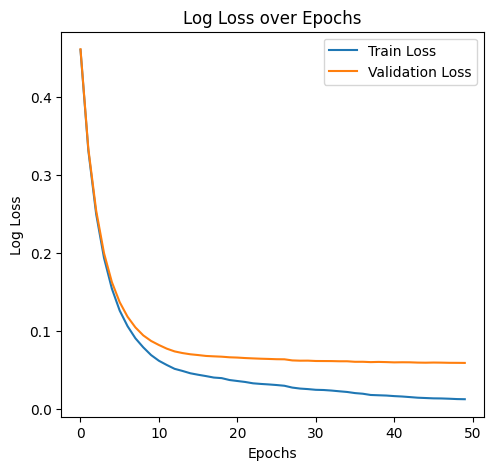

In [100]:
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
results = best_model.evals_result()

epochs = range(len(results['validation_0']['logloss']))

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, results['validation_0']['logloss'], label='Train Loss')
plt.plot(epochs, results['validation_1']['logloss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Log Loss over Epochs')
plt.legend()

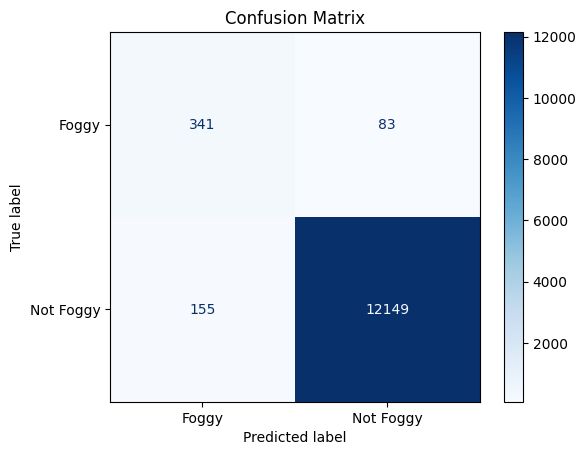

In [101]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # 1=foggy, 0=not foggy
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Foggy", "Not Foggy"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [102]:
# Get indices of false positives (predicted 1, actual 0)
false_positives = X_test[(y_pred == 1) & (y_test == 0)].head(10)

# Get indices of false negatives (predicted 0, actual 1)
false_negatives = X_test[(y_pred == 0) & (y_test == 1)].head(10)

print("False Positives:")
print(false_positives)

print("\nFalse Negatives:")
print(false_negatives)

False Positives:
        hour  temp  dew_point  temp_dew_point_diff  humidity  pressure  \
585976     6   6.0        5.6                  0.4      97.0    1016.0   
561184     6   7.3        7.0                  0.3      98.0    1017.0   
569994     8   8.6        8.3                  0.3      98.0    1006.3   
542848     6   6.6        6.3                  0.3      98.0    1020.3   
587989     3  -1.0       -1.1                  0.1      99.0    1030.5   
574000     6   9.0        8.7                  0.3      98.0    1021.7   
587155     9  10.9        9.3                  1.6      90.0    1029.1   
560437     3   2.6        2.5                  0.1      99.0    1029.6   
561105    23   4.2        4.2                  0.0     100.0    1024.5   
571211     1   5.4        5.3                  0.1      99.0    1025.5   

        wind_speed  wind_gust  
585976         3.2        6.0  
561184         4.3        8.0  
569994         2.5        5.0  
542848         2.9        7.0  
587989  

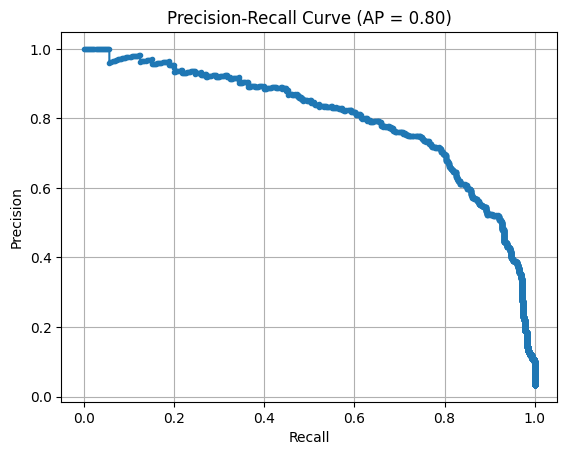

In [103]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_scores = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (foggy)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap:.2f})')
plt.grid()
plt.show()


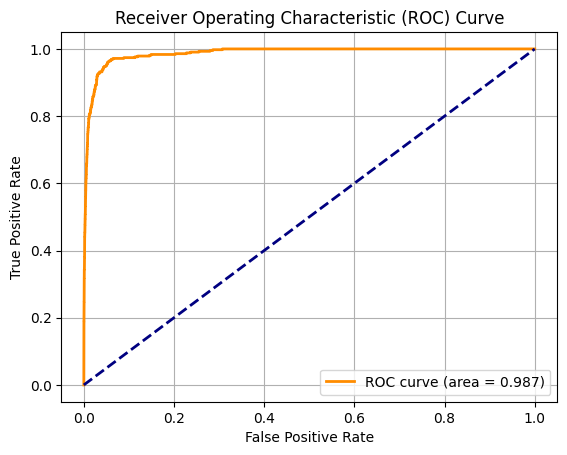

In [104]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [93]:
best_model.save_model("../backend/forecast/xgb_foggy.json")